In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 224
BATCH_SIZE = 64
CHANNELS=3
EPOCH=25

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4188 files belonging to 4 classes.


In [4]:
class_names = dataset.class_names
print(class_names)
print(len(dataset))

['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']
66


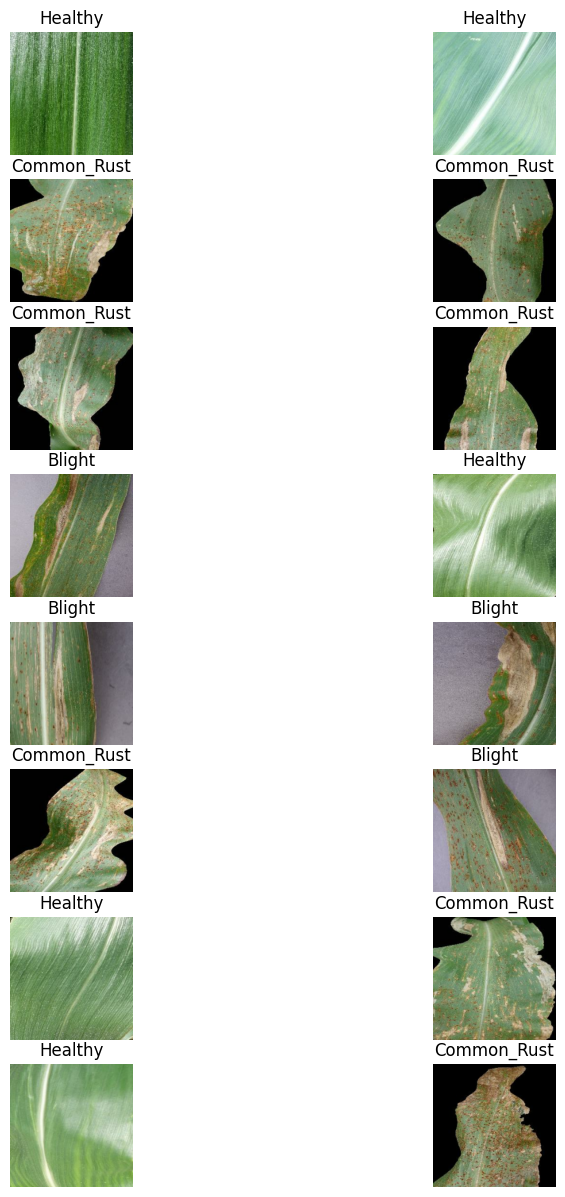

In [5]:
plt.figure(figsize=(10,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(8,2,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    

In [11]:
# 80% training
train_size = 0.8
print(round(len(dataset)*train_size))

53


In [12]:
train_ds = dataset.take(53)
print(len(train_ds))

66


In [17]:
test_ds = dataset.skip(53)
print(len(test_ds))

13


In [18]:
val_size = 0.1
print(round(len(dataset)*val_size))

7


In [19]:
val_ds = test_ds.take(7)
print(len(val_ds))

7


In [20]:
test_ds = test_ds.skip(7)
print(len(test_ds))

6


In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = round(train_split * ds_size)
    val_size = round(val_split * ds_size)
    test_size = round(test_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [7]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [8]:
len(train_ds)

53

In [9]:
len(test_ds)

6

In [10]:
len(val_ds)

7

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
data_augmetation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = models.Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), strides=(2, 2)),
    
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4096, activation='relu'),
    layers.Dense(4, activation='softmax')
])

model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCH,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/25
53/53 [==============================] - 1391s 26s/step - loss: 110.4031 - accuracy: 0.3287 - val_loss: 1.1368 - val_accuracy: 0.4643
Epoch 2/25
53/53 [==============================] - 1260s 24s/step - loss: 1.1666 - accuracy: 0.5106 - val_loss: 1.0427 - val_accuracy: 0.4866
Epoch 3/25
53/53 [==============================] - 1169s 22s/step - loss: 13.9758 - accuracy: 0.5091 - val_loss: 0.9238 - val_accuracy: 0.5290
Epoch 4/25
53/53 [==============================] - 1165s 22s/step - loss: 0.8657 - accuracy: 0.6324 - val_loss: 0.7951 - val_accuracy: 0.6897
Epoch 5/25
53/53 [==============================] - 1147s 22s/step - loss: 0.6264 - accuracy: 0.7397 - val_loss: 0.4086 - val_accuracy: 0.8058
Epoch 6/25
53/53 [==============================] - 1132s 21s/step - loss: 0.4384 - accuracy: 0.8178 - val_loss: 0.3906 - val_accuracy: 0.8281
Epoch 7/25
53/53 [==============================] - 1143s 22s/step - loss: 0.3702 - accuracy: 0.8438 - val_loss: 0.3353 - val_accuracy: 0.8

In [24]:
scores = model.evaluate(test_ds)
print(scores)
print(history.params)

6/6 [==============================] - 35s 5s/step - loss: 0.1354 - accuracy: 0.9479
[0.1353960782289505, 0.9479166865348816]


In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

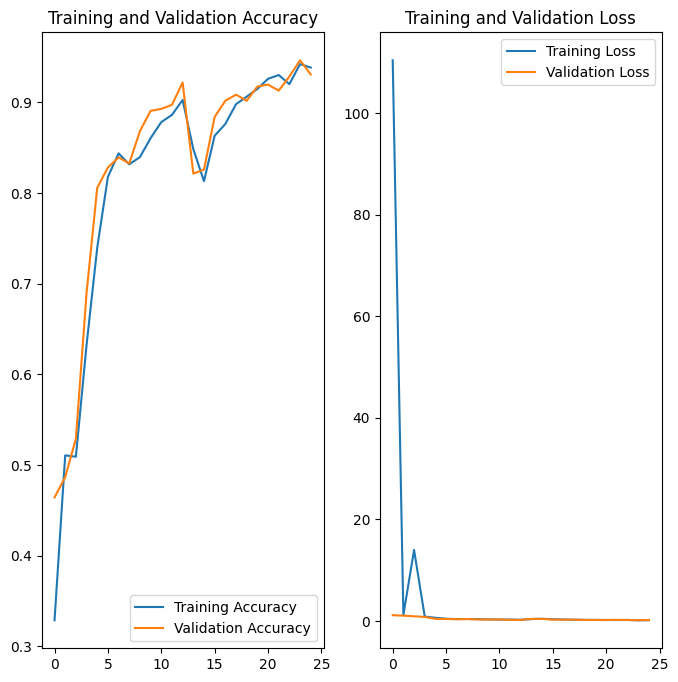

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH), acc, label='Training Accuracy')
plt.plot(range(EPOCH), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCH), loss, label='Training Loss')
plt.plot(range(EPOCH), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predict First Image
First Image's Actual Label: Healthy
2/2 [==============================] - 4s 2s/step
Predicted Label: Common_Rust


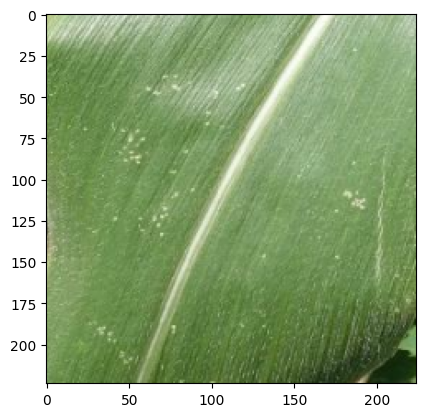

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("Predict First Image")
    plt.imshow(first_image)
    print("First Image's Actual Label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 101ms/step


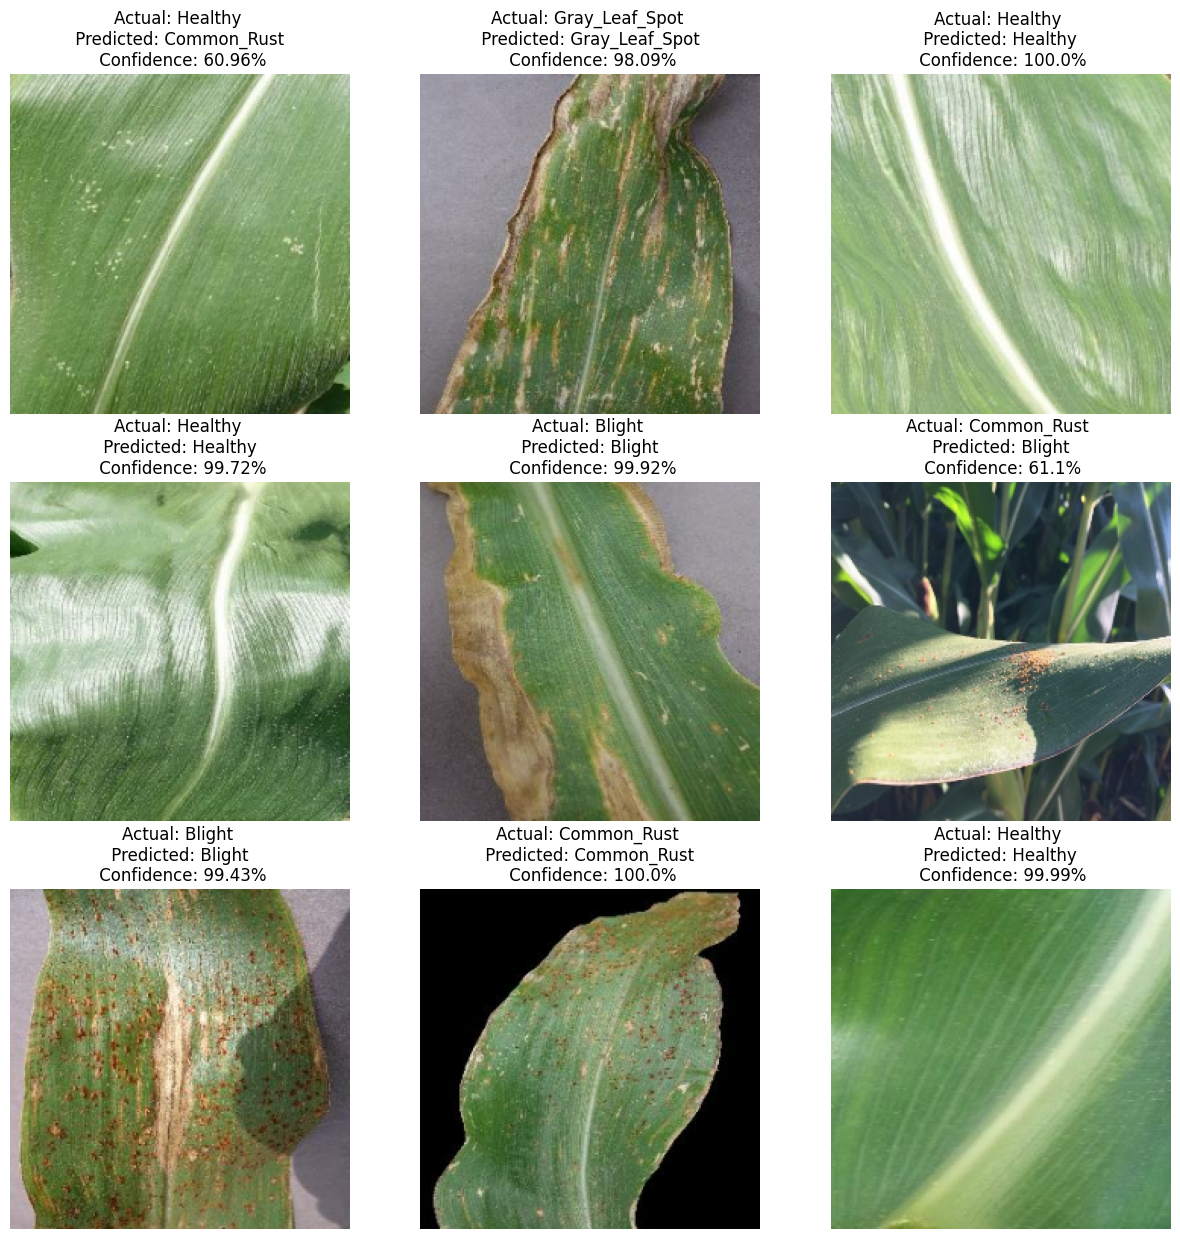

In [72]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class} \n Predicted: {predicted_class} \n Confidence: {confidence}%")
        
        plt.axis("off")

In [57]:
import os
model_version = max(int(i) for i in os.listdir("models"))+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/2\assets


INFO:tensorflow:Assets written to: models/2\assets
